Raw data: 12 MNIST runs, 6 Selective runs

MNIST datasets found: {'MNIST': 6, 'FashionMNIST': 6}
MNIST optimizers found: {'md': 6, 'gd': 6}
Selective optimizers found: {'unknown': 6}


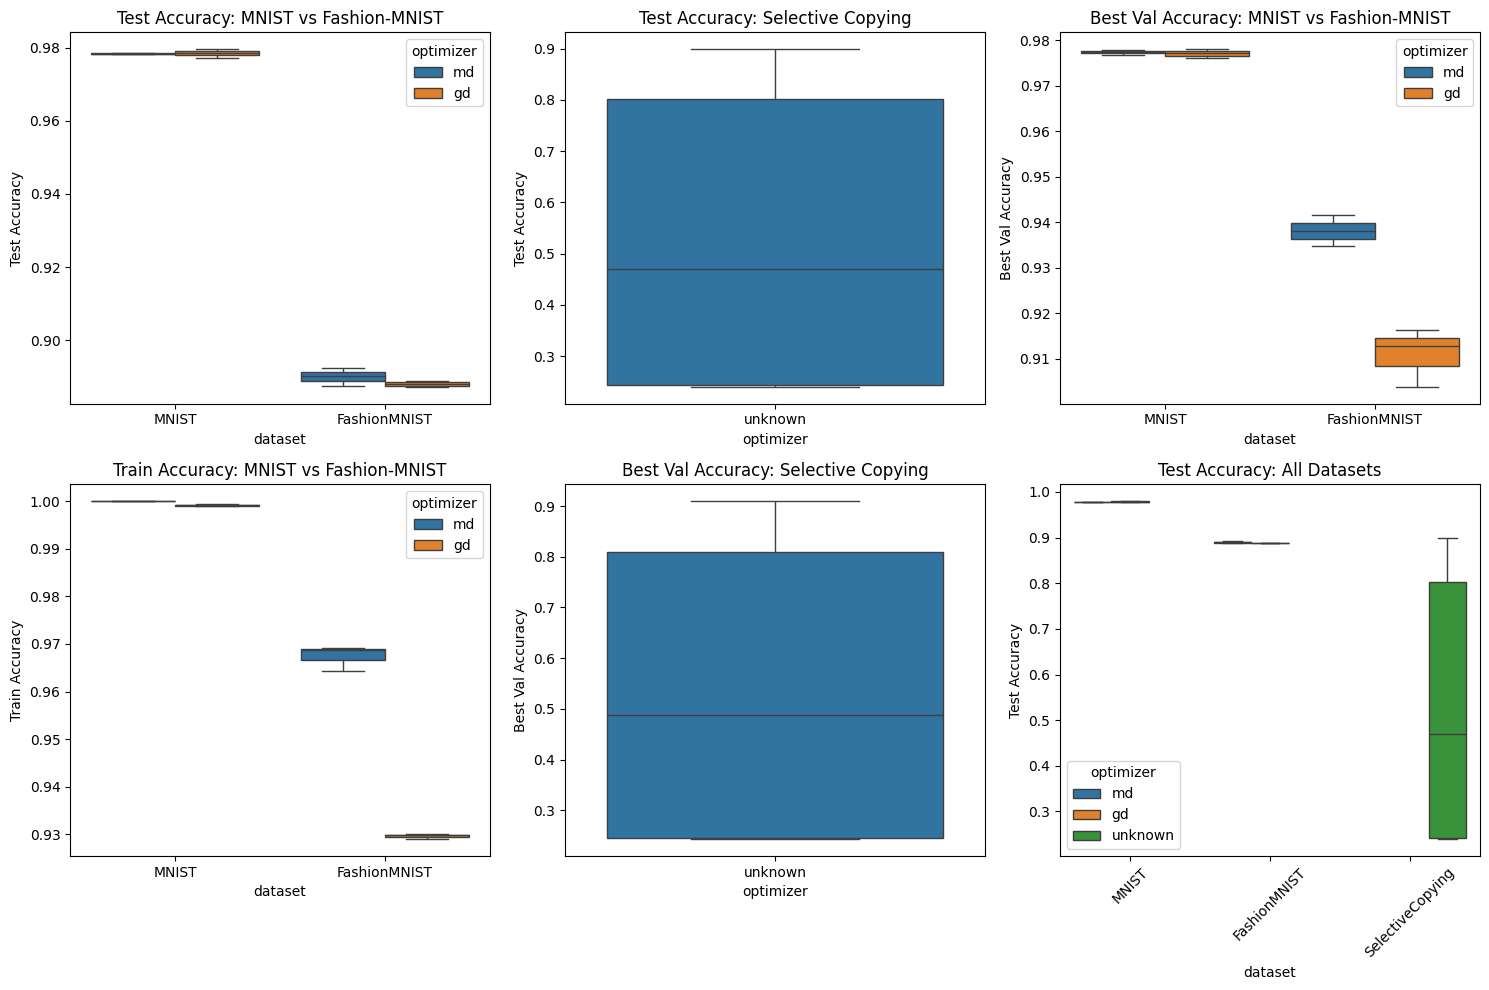


SUMMARY STATISTICS

MNIST/Fashion-MNIST Results:
                          mean     std  count
dataset      optimizer                       
FashionMNIST gd         0.8880  0.0009      3
             md         0.8900  0.0024      3
MNIST        gd         0.9785  0.0012      3
             md         0.9784  0.0002      3

Selective Copying Results:
             mean     std  count
optimizer                       
unknown    0.5265  0.3184      6


In [1]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
ENTITY = "hp-learning-rules"

def fetch_project_data(project_name):
    """Fetch all runs from a wandb project"""
    api = wandb.Api()
    runs = api.runs(f"{ENTITY}/{project_name}")
    
    data = []
    for run in runs:
        row = {'run_id': run.id, 'run_name': run.name, 'state': run.state}
        
        # Add all config items
        for key, value in run.config.items():
            row[f'config_{key}'] = value
        
        # Add all summary metrics
        for key, value in run.summary._json_dict.items():
            if not key.startswith('_'):
                row[key] = value
        
        data.append(row)
    
    return pd.DataFrame(data)

def clean_data(df, project_type):
    """Clean and process data for both projects"""
    # Filter completed runs
    df = df[df['state'] == 'finished'].copy()
    
    if project_type == 'mnist':
        # Extract dataset type from config_data
        df['dataset'] = df['config_data'].apply(lambda x: 
            'MNIST' if 'mnist_datamodule.MNISTDataModule' in str(x) else
            'FashionMNIST' if 'mnist_datamodule.FashionMNISTDataModule' in str(x) else 
            'SelectiveCopying' if 'selectivecopying_datamodule.SelectiveCopyingDataModule' in str(x) else
            'Unknown'
        )
        
        # Extract optimizer type from config_model
        df['optimizer'] = df['config_model'].apply(lambda x: 
            x.get('optimizer', {}).get('update_alg', 'unknown') if isinstance(x, dict) else 'unknown'
        )
    
    else:  # selective copying
        # Dataset is always Selective Copying
        df['dataset'] = 'SelectiveCopying'
        
        # Extract optimizer type from config_optimizer
        df['optimizer'] = df['config_optimizer'].apply(lambda x: 
            x.get('update_alg', 'unknown') if isinstance(x, dict) else 'unknown'
        )
    
    return df

def plot_comparison(mnist_df, selective_df):
    """Create simple comparison plots"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Plot 1: MNIST/Fashion test accuracy
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='test/acc', hue='optimizer', ax=axes[0,0])
        axes[0,0].set_title('Test Accuracy: MNIST vs Fashion-MNIST')
        axes[0,0].set_ylabel('Test Accuracy')
    else:
        axes[0,0].text(0.5, 0.5, 'No MNIST test/acc data', ha='center', va='center')
    
    # Plot 2: Selective Copying test accuracy
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='test/acc', ax=axes[0,1])
        axes[0,1].set_title('Test Accuracy: Selective Copying')
        axes[0,1].set_ylabel('Test Accuracy')
    else:
        axes[0,1].text(0.5, 0.5, 'No Selective test/acc data', ha='center', va='center')
    
    # Plot 3: MNIST/Fashion validation accuracy
    if len(mnist_df) > 0 and 'val/acc_best' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='val/acc_best', hue='optimizer', ax=axes[0,2])
        axes[0,2].set_title('Best Val Accuracy: MNIST vs Fashion-MNIST')
        axes[0,2].set_ylabel('Best Val Accuracy')
    else:
        axes[0,2].text(0.5, 0.5, 'No MNIST val/acc_best data', ha='center', va='center')
    
    # Plot 4: MNIST/Fashion train accuracy
    if len(mnist_df) > 0 and 'train/acc' in mnist_df.columns:
        sns.boxplot(data=mnist_df, x='dataset', y='train/acc', hue='optimizer', ax=axes[1,0])
        axes[1,0].set_title('Train Accuracy: MNIST vs Fashion-MNIST')
        axes[1,0].set_ylabel('Train Accuracy')
    else:
        axes[1,0].text(0.5, 0.5, 'No MNIST train/acc data', ha='center', va='center')
    
    # Plot 5: Selective Copying validation accuracy
    if len(selective_df) > 0 and 'val/acc_best' in selective_df.columns:
        sns.boxplot(data=selective_df, x='optimizer', y='val/acc_best', ax=axes[1,1])
        axes[1,1].set_title('Best Val Accuracy: Selective Copying')
        axes[1,1].set_ylabel('Best Val Accuracy')
    else:
        axes[1,1].text(0.5, 0.5, 'No Selective val/acc_best data', ha='center', va='center')
    
    # Plot 6: Combined test accuracy
    combined_data = []
    if len(mnist_df) > 0 and 'test/acc' in mnist_df.columns:
        for _, row in mnist_df.iterrows():
            if pd.notna(row['test/acc']):
                combined_data.append({
                    'dataset': row['dataset'],
                    'optimizer': row['optimizer'],
                    'test_acc': row['test/acc']
                })
    
    if len(selective_df) > 0 and 'test/acc' in selective_df.columns:
        for _, row in selective_df.iterrows():
            if pd.notna(row['test/acc']):
                combined_data.append({
                    'dataset': 'SelectiveCopying',
                    'optimizer': row['optimizer'],
                    'test_acc': row['test/acc']
                })
    
    if combined_data:
        combined_df = pd.DataFrame(combined_data)
        sns.boxplot(data=combined_df, x='dataset', y='test_acc', hue='optimizer', ax=axes[1,2])
        axes[1,2].set_title('Test Accuracy: All Datasets')
        axes[1,2].set_ylabel('Test Accuracy')
        axes[1,2].tick_params(axis='x', rotation=45)
    else:
        axes[1,2].text(0.5, 0.5, 'No combined test/acc data', ha='center', va='center')
    
    plt.tight_layout()
    plt.show()

def print_summary(mnist_df, selective_df):
    """Print summary statistics"""
    print("\n" + "="*60)
    print("SUMMARY STATISTICS")
    print("="*60)
    
    # MNIST/Fashion-MNIST
    if len(mnist_df) > 0:
        print("\nMNIST/Fashion-MNIST Results:")
        if 'test/acc' in mnist_df.columns:
            summary = mnist_df.groupby(['dataset', 'optimizer'])['test/acc'].agg(['mean', 'std', 'count'])
            print(summary.round(4))
    
    # Selective Copying
    if len(selective_df) > 0:
        print("\nSelective Copying Results:")
        if 'test/acc' in selective_df.columns:
            summary = selective_df.groupby('optimizer')['test/acc'].agg(['mean', 'std', 'count'])
            print(summary.round(4))



mnist_df = fetch_project_data("prune-tests-grid")
selective_df = fetch_project_data("prune-tests-selcopy-grid")

print(f"Raw data: {len(mnist_df)} MNIST runs, {len(selective_df)} Selective runs")

mnist_clean = clean_data(mnist_df, 'mnist')
selective_clean = clean_data(selective_df, 'selective')

print(f"\nMNIST datasets found: {mnist_clean['dataset'].value_counts().to_dict()}")
print(f"MNIST optimizers found: {mnist_clean['optimizer'].value_counts().to_dict()}")
print(f"Selective optimizers found: {selective_clean['optimizer'].value_counts().to_dict()}")


plot_comparison(mnist_clean, selective_clean)
print_summary(mnist_clean, selective_clean)
results = {
    'mnist_clean': mnist_clean,
    'selective_clean': selective_clean,
    'mnist_raw': mnist_df,
    'selective_raw': selective_df
}

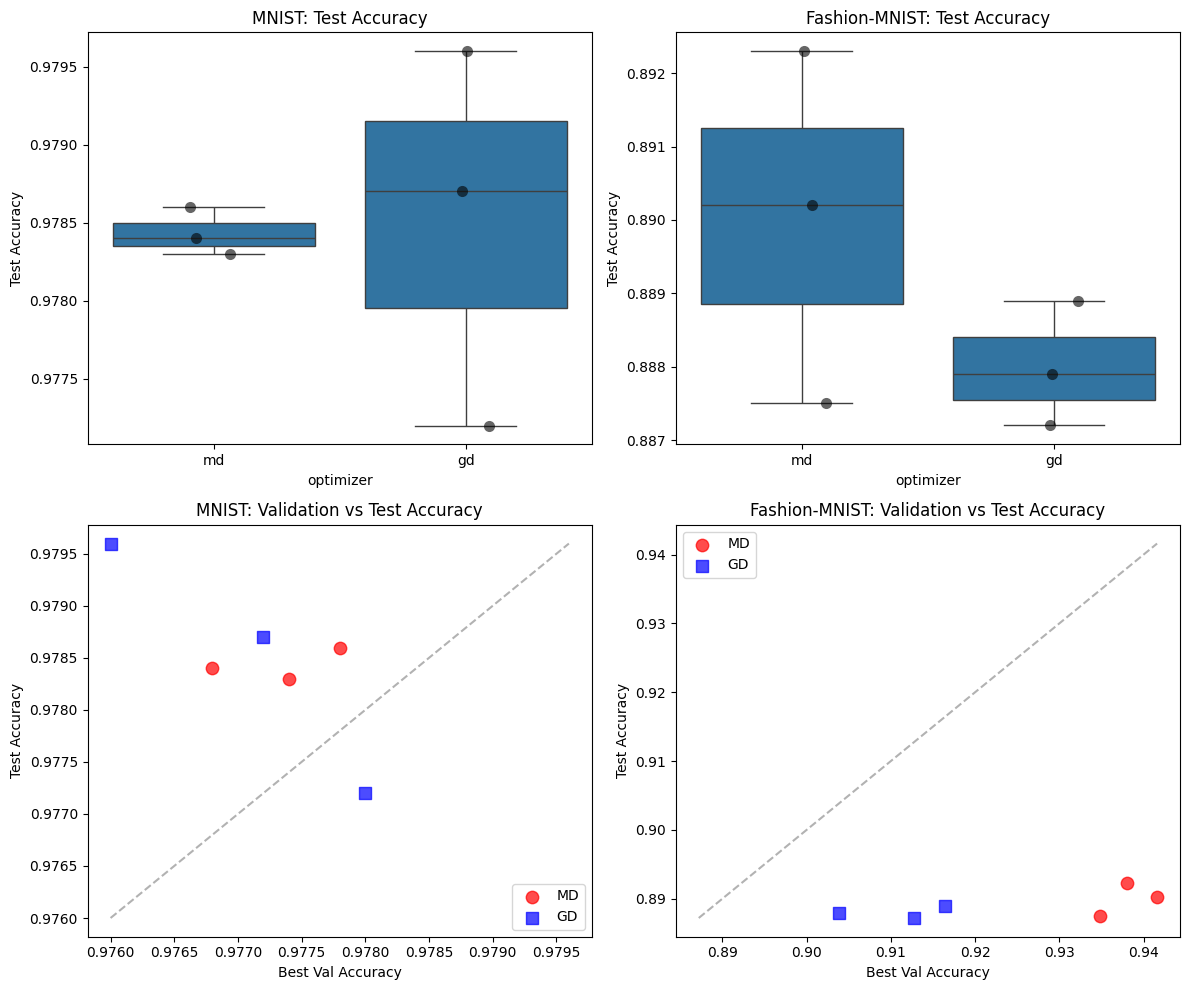

MNIST & Fashion-MNIST Analysis

test/acc:
  MD: 0.9784 ± 0.0002 (n=3)
  GD: 0.9785 ± 0.0012 (n=3)

val/acc_best:
  MD: 0.9773 ± 0.0005 (n=3)
  GD: 0.9771 ± 0.0010 (n=3)

train/acc:
  MD: 1.0000 ± 0.0000 (n=3)
  GD: 0.9992 ± 0.0001 (n=3)

test/acc:
  MD: 0.8900 ± 0.0024 (n=3)
  GD: 0.8880 ± 0.0009 (n=3)

val/acc_best:
  MD: 0.9381 ± 0.0034 (n=3)
  GD: 0.9110 ± 0.0065 (n=3)

train/acc:
  MD: 0.9674 ± 0.0026 (n=3)
  GD: 0.9296 ± 0.0005 (n=3)


In [2]:
def plot_mnist_analysis(mnist_df):
    """Analyze MNIST and Fashion-MNIST results separately"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Filter data for each dataset
    mnist_data = mnist_df[mnist_df['dataset'] == 'MNIST']
    fashion_data = mnist_df[mnist_df['dataset'] == 'FashionMNIST']
    
    # Plot 1: MNIST results
    if len(mnist_data) > 0 and 'test/acc' in mnist_data.columns:
        sns.boxplot(data=mnist_data, x='optimizer', y='test/acc', ax=axes[0,0])
        axes[0,0].set_title('MNIST: Test Accuracy')
        axes[0,0].set_ylabel('Test Accuracy')
        
        # Add individual points
        sns.stripplot(data=mnist_data, x='optimizer', y='test/acc', 
                     ax=axes[0,0], color='black', alpha=0.6, size=8)
    
    # Plot 2: Fashion-MNIST results  
    if len(fashion_data) > 0 and 'test/acc' in fashion_data.columns:
        sns.boxplot(data=fashion_data, x='optimizer', y='test/acc', ax=axes[0,1])
        axes[0,1].set_title('Fashion-MNIST: Test Accuracy')
        axes[0,1].set_ylabel('Test Accuracy')
        
        # Add individual points
        sns.stripplot(data=fashion_data, x='optimizer', y='test/acc', 
                     ax=axes[0,1], color='black', alpha=0.6, size=8)
    
    # Plot 3: MNIST validation vs test
    if len(mnist_data) > 0 and 'test/acc' in mnist_data.columns and 'val/acc_best' in mnist_data.columns:
        for opt, marker, color in [('md', 'o', 'red'), ('gd', 's', 'blue')]:
            data = mnist_data[mnist_data['optimizer'] == opt]
            axes[1,0].scatter(data['val/acc_best'], data['test/acc'], 
                             alpha=0.7, label=opt.upper(), marker=marker, s=80, color=color)
        
        axes[1,0].set_title('MNIST: Validation vs Test Accuracy')
        axes[1,0].set_xlabel('Best Val Accuracy')
        axes[1,0].set_ylabel('Test Accuracy')
        axes[1,0].legend()
        
        # Add diagonal line
        min_acc = min(mnist_data['val/acc_best'].min(), mnist_data['test/acc'].min())
        max_acc = max(mnist_data['val/acc_best'].max(), mnist_data['test/acc'].max())
        axes[1,0].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
    
    # Plot 4: Fashion-MNIST validation vs test
    if len(fashion_data) > 0 and 'test/acc' in fashion_data.columns and 'val/acc_best' in fashion_data.columns:
        for opt, marker, color in [('md', 'o', 'red'), ('gd', 's', 'blue')]:
            data = fashion_data[fashion_data['optimizer'] == opt]
            axes[1,1].scatter(data['val/acc_best'], data['test/acc'], 
                             alpha=0.7, label=opt.upper(), marker=marker, s=80, color=color)
        
        axes[1,1].set_title('Fashion-MNIST: Validation vs Test Accuracy')
        axes[1,1].set_xlabel('Best Val Accuracy')
        axes[1,1].set_ylabel('Test Accuracy')
        axes[1,1].legend()
        
        # Add diagonal line
        min_acc = min(fashion_data['val/acc_best'].min(), fashion_data['test/acc'].min())
        max_acc = max(fashion_data['val/acc_best'].max(), fashion_data['test/acc'].max())
        axes[1,1].plot([min_acc, max_acc], [min_acc, max_acc], 'k--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def print_mnist_stats(mnist_df):
    """Print detailed statistics for MNIST/Fashion-MNIST"""
    print("="*60)
    print("MNIST & Fashion-MNIST Analysis")
    print("="*60)
    
    for dataset in ['MNIST', 'FashionMNIST']:
        data = mnist_df[mnist_df['dataset'] == dataset]
        if len(data) == 0:
            continue
        
        
        for metric in ['test/acc', 'val/acc_best', 'train/acc']:
            if metric in data.columns:
                print(f"\n{metric}:")
                for opt in ['md', 'gd']:
                    opt_data = data[data['optimizer'] == opt][metric].dropna()
                    if len(opt_data) > 0:
                        print(f"  {opt.upper()}: {opt_data.mean():.4f} ± {opt_data.std():.4f} (n={len(opt_data)})")
                
            

# Usage:
plot_mnist_analysis(mnist_clean)
print_mnist_stats(mnist_clean)

In [3]:
colors = {
    'SGD':     '#5fad56',
    'MD':      '#2b9eb3',
    'SGD+Mom': '#0b6e4f',
    'MD+Mom':  '#084c61'
}
plt.rcParams["font.family"] = "Times New Roman"

In [6]:
import ast

def clean_data(df, project_type):
    """Clean and process data for both projects"""
    df = df[df['state'] == 'finished'].copy()
    
    if project_type == 'mnist':
        # Extract dataset type from config_data
        df['dataset'] = df['config_data'].apply(lambda x: 
            'MNIST' if 'mnist_datamodule.MNISTDataModule' in str(x) else
            'FashionMNIST' if 'mnist_datamodule.FashionMNISTDataModule' in str(x) else 
            'SelectiveCopying' if 'selectivecopying_datamodule.SelectiveCopyingDataModule' in str(x) else
            'Unknown'
        )
        
        # Extract optimizer type from config_model
        df['optimizer'] = df['config_model'].apply(lambda x: 
            x.get('optimizer', {}).get('update_alg', 'unknown') if isinstance(x, dict) else 'unknown'
        )
    
    else:  # selective copying
        df['dataset'] = 'SelectiveCopying'
        
        # Extract optimizer type from config_optimizer - parse string as dict
        def extract_optimizer(x):
            try:
                if isinstance(x, dict):
                    return x.get('update_alg', 'unknown')
                elif isinstance(x, str):
                    parsed = ast.literal_eval(x)
                    return parsed.get('update_alg', 'unknown')
                else:
                    return 'unknown'
            except:
                return 'unknown'
        
        df['optimizer'] = df['config_optimizer'].apply(extract_optimizer)
    
    return df

# Re-run the cleaning
selective_clean = clean_data(selective_df, 'selective')

# Check if it worked
print(f"Optimizer values:\n{selective_clean['optimizer'].value_counts()}")
print(f"\nSample data:")
print(selective_clean[['run_name', 'optimizer', 'test/acc']].head())

Optimizer values:
optimizer
md    3
gd    3
Name: count, dtype: int64

Sample data:
           run_name optimizer  test/acc
0     copper-wind-3        md    0.8374
1       deep-tree-4        gd    0.2398
2  apricot-shadow-5        md    0.6966
3     mild-plasma-6        gd    0.2422
4  electric-disco-7        md    0.8988


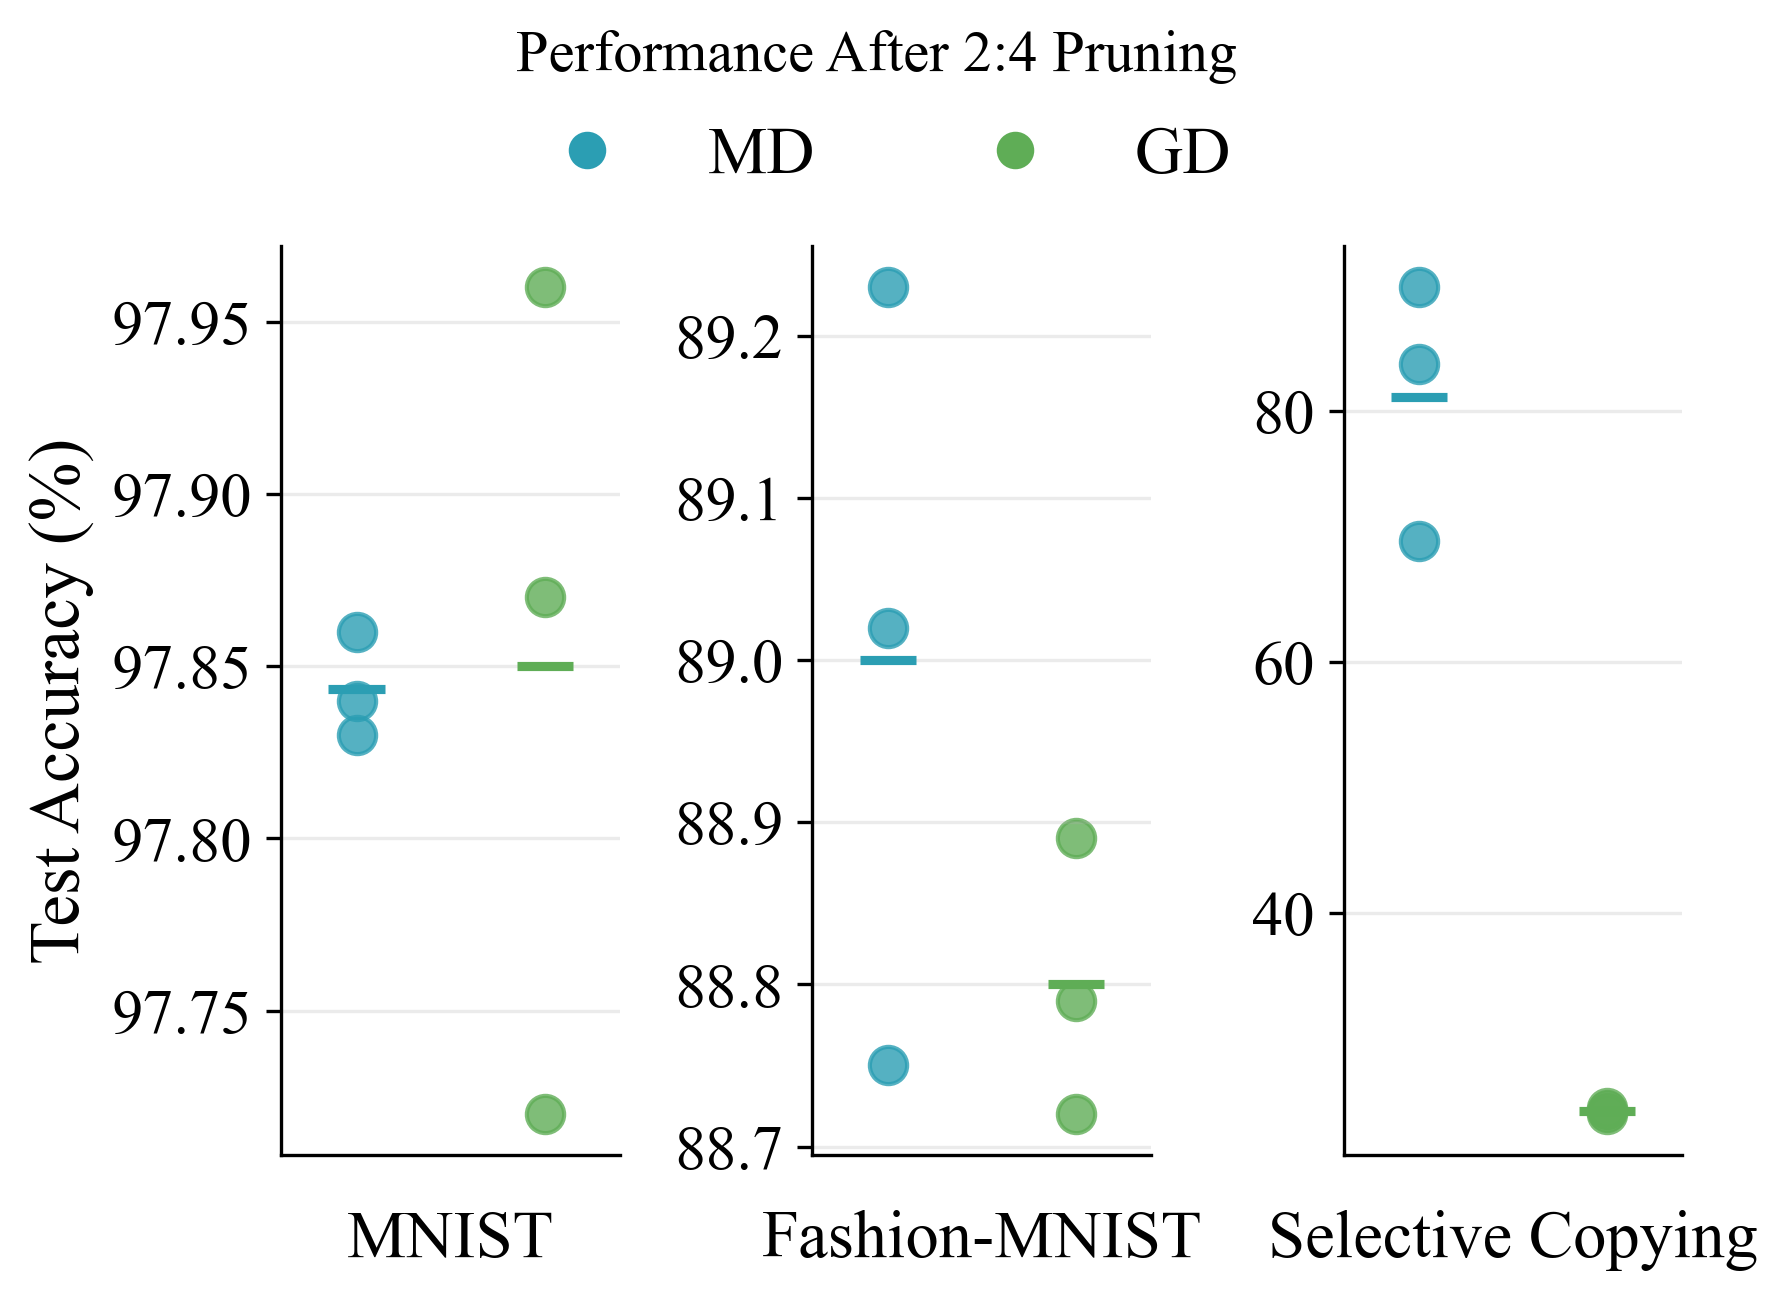

In [7]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def create_individual_runs_plot(mnist_df, selective_df):
    """Show individual run performance with subtitles below and a top legend."""
    fig, axes = plt.subplots(1, 3, figsize=(6, 4), dpi=300)
    plt.rcParams.update({'font.size': 12})

    # helper to plot one panel
    def panel(ax, df, dataset_label):
        md_acc = df[df['optimizer'] == 'md']['test/acc'].to_numpy() * 100
        gd_acc = df[df['optimizer'] == 'gd']['test/acc'].to_numpy() * 100

        # MD/GD scatters at x=0 and x=1
        if md_acc.size:
            ax.scatter(np.zeros_like(md_acc), md_acc, s=80, alpha=0.8,
                       label='MD', color=colors['MD'])
            ax.hlines(md_acc.mean(), -0.15, 0.15, colors=colors['MD'], linewidth=2.2)
        if gd_acc.size:
            ax.scatter(np.ones_like(gd_acc), gd_acc, s=80, alpha=0.8,
                       label='GD', color=colors['SGD'])
            ax.hlines(gd_acc.mean(), 0.85, 1.15, colors=colors['SGD'], linewidth=2.2)

        # y label only on the first panel
        ax.set_ylabel('Test Accuracy (%)', fontsize=17) if ax is axes[0] else ax.set_ylabel('')

        # remove x-axis scale entirely
        ax.set_xticks([])
        ax.set_xlim(-0.4, 1.4)

        # subtitle below the axes (centered)
        ax.text(0.5, -0.06, dataset_label, transform=ax.transAxes,
                ha='center', va='top', fontsize=16)

        # tidy
        ax.grid(True, alpha=0.25)
        ax.tick_params(labelsize=15)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

    # ---- Panel 1: MNIST ----
    mnist_data = mnist_df[mnist_df['dataset'] == 'MNIST']
    if len(mnist_data) and 'test/acc' in mnist_data.columns:
        panel(axes[0], mnist_data, 'MNIST')

    # ---- Panel 2: Fashion-MNIST ----
    fashion_data = mnist_df[mnist_df['dataset'] == 'FashionMNIST']
    if len(fashion_data) and 'test/acc' in fashion_data.columns:
        panel(axes[1], fashion_data, 'Fashion-MNIST')

    # ---- Panel 3: Selective Copying ----
    if len(selective_df) and 'test/acc' in selective_df.columns:
        panel(axes[2], selective_df, 'Selective Copying')

    # Top legend (MD / GD only)
    legend_handles = [
        Line2D([0], [0], marker='o', linestyle='None', color=colors['MD'],
               label='MD', markersize=8),
        Line2D([0], [0], marker='o', linestyle='None', color=colors['SGD'],
               label='GD', markersize=8),
    ]
    fig.legend(handles=legend_handles, loc='upper center', ncol=2,
               bbox_to_anchor=(0.5, 1.05), frameon=False, fontsize=16)

    fig.suptitle('Performance After 2:4 Pruning', fontsize=14, y=1.08)
    plt.tight_layout()
    plt.subplots_adjust(top=0.90)  # leave room for legend/suptitle
    plt.show()

# Usage:
create_individual_runs_plot(mnist_clean, selective_clean)